In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, CenterCrop, ToTensor, Normalize, Resize

import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt

/home/ghdrnjs/anaconda3/envs/searle/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5], std = [0.5])
])

transform_normal = Compose([
    ToTensor()
])

In [3]:
# torchvision에서 MNIST 데이터 Load

train_data = datasets.MNIST(
    root="./data/MNIST",
    train=True,
    download=True,
    transform=transform_normal
)

test_data = datasets.MNIST(
    root="./data/MNIST/",
    train=False,
    download=True,
    transform=transform_normal
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
train_dataset, val_dataset = random_split(train_data, [55000, 5000])

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

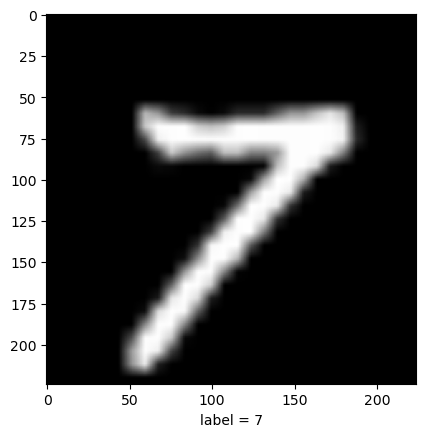

In [10]:
image = train_dataset[0]
image = image[0].squeeze(0)
plt.imshow(image, cmap="gray")
plt.xlabel(f"label = {train_dataset[0][1]}")
plt.show()

In [ ]:
# MNIST 단일 데이터의 size
image = train_dataset[0][0]
image.size()

torch.Size([1, 28, 28])

In [ ]:
# Embedding Dimension에 관한 고찰
# 기본적인 ViT 설정
    # ViT-Tiny : 192
    # ViT-Small : 384
    # ViT-Base(CLIP ViT-B/32 Backbone의 임베딩 차원도 768) : 768
    # ViT-Large : 1024 
    # ViT-Huge : 1280

# MNIST 데이터셋의 경우 고차원의 Embedding Dimension 까지는 필요하지 않음.

In [8]:
# Patch Embedding Projection
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Conv2d를 통한 패치 분할 및 임베딩
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    # forward 진행
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

In [ ]:
# CLS token과 Positional Embedding을 추가한 Embedding Layer Class
class EmbeddingLayer(nn.Module):
    def __init__(self, img_size=28, embed_dim=64, patch_size=4):
        super().__init__()
        self.num_patches = int(pow(img_size, 2)/pow(patch_size, 2)) 
        self.proj = PatchEmbedding(patch_size=patch_size, in_channels=1, embed_dim=embed_dim)
        self.cls = nn.Parameter(torch.randn(1, 1, embed_dim))
        # positional embedding은 모든 패치 개수 + 1, embed_dim은 동일
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches+1, embed_dim))
        self.embed_dim = embed_dim

    def forward(self, x):
        x = self.proj(x)
        x = torch.cat([x, self.cls.repeat(x.shape[0], 1, 1)], dim=1)
        x = x + self.pos_embed.repeat(x.shape[0], 1, 1)
        return x

In [ ]:
# Loader의 배치 단위 실행
projection = PatchEmbedding()
data_total = []
for batch in train_loader:
    data = batch[0]
    label = batch[1]
    forward = projection(data)
    data_total.append(forward)
value = torch.vstack(data_total)

# [총 데이터 개수, Embedding Dimension, patch_size, patch_size]
# 이를 transformer의 입력단에 넣기 위해서 Flatten과 transpose 과정이 필요.
# nn.Flatten()을 호출하여 사용 or tensor 자체에서 flatten
# 
# x.transpose로 [batch_size, patch_size**2, embed_dim]
value.shape

torch.Size([55000, 49, 64])

In [24]:
projection = EmbeddingLayer()
data_total = []
for batch in train_loader:
    data = batch[0]
    label = batch[1]
    forward = projection(data)
    data_total.append(forward)
value = torch.vstack(data_total)

# 이렇게 하면 Embedding Layer 구성 끝
value.shape

torch.Size([55000, 50, 64])

In [42]:
# Scale Dot Product Attention 구현
from typing import Optional
import math

class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax()

    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, mask:torch.Tensor=None, e:float=1e-12):
        # input is 4 dimension vector
        # [batch_size, head, length, embed_dimension]
        batch_size, head, length, embed_dim = k.size()
        k_t = k.view(batch_size, head, embed_dim, length)
        score = q @ k_t / math.sqrt(embed_dim)

        if mask is not None:
            score = score.masked_fill(mask == 0, -e)

        score = self.softmax(score)
        v = score @ v
        return score, v

In [47]:
# Multi Head Attention 구현
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

        # 최종 출력 변환 (concat 이후 다시 d_model로 변환)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        
        # nn.Linear를 통과하여 Q, K, V Matrix 생성
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)

        Q = Q.view(batch_size, self.n_head, seq_len, self.d_head)
        K = K.view(batch_size, self.n_head, seq_len, self.d_head)
        V = V.view(batch_size, self.n_head, seq_len, self.d_head)

        # attn_weights가 score
        # attn_output이 v
        attn_weights, attn_output = self.attention(Q, K, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.W_O(attn_output)

        return output

In [53]:
# Feed Forward Network 구현
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_size=64, expansion=4, drop_out = 0.5):
        super().__init__()
        self.embed_size = embed_size
        self.expansion = expansion
        self.fc1 = nn.Linear(embed_size, embed_size*expansion)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(drop_out)
        self.fc2 = nn.Linear(embed_size * expansion, embed_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(self.gelu(x)) 
        x = self.fc2(x)
        return x

In [49]:
projection = EmbeddingLayer()
mha = MultiHeadAttention(64, 8)
data_total = []

for batch in train_loader:
    data = batch[0]
    label = batch[1]
    forward = projection(data)
    forward = mha(forward)
    data_total.append(forward)
value = torch.vstack(data_total)
value.shape

/tmp/ipykernel_2979633/265417870.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = self.softmax(score)


torch.Size([55000, 50, 64])

In [54]:
## 본격적인 Vision Transformer 구성
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim=64, n_head=8):
        super().__init__()
        self.proj = EmbeddingLayer(embed_dim=embed_dim)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mha = MultiHeadAttention(d_model=embed_dim, n_head=n_head)
        self.ffn = FeedForwardNetwork()
    
    def forward(self, x):
        x = self.proj(x) # Embedding Layer
        x = self.ln1(x) # LayerNorm 1
        mha_value = self.mha(x) # Multi-Head Self Attention
        x = x + mha_value # Residual
        x = self.ln2(x) # LayerNorm 2
        x = self.ffn(x)
        return x

In [55]:
vit = VisionTransformer()
data_total = []

for batch in train_loader:
    data = batch[0]
    label = batch[1]
    forward = vit(data)
    data_total.append(forward)
value = torch.vstack(data_total)
value.shape

/tmp/ipykernel_2979633/265417870.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = self.softmax(score)


torch.Size([55000, 50, 64])